In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

In [59]:
# train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
class DataGen(keras.utils.Sequence): #keras.utils.Sequence
    def __init__(self, ids, path, batch_size=8, image_size=512):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
    
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, "masks\\")
        prefix =  "0"*(5-len(id_name)) + id_name
        all_masks = [filename for filename in os.listdir(mask_path) if filename.startswith(prefix)]

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) 
            # _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)
            
        ## Normalizaing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            images.append(_img)
            masks.append(_mask)
        
        images = np.array(images)
        masks  = np.array(masks)
        
        return images, masks
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [60]:
test = DataGen(["0","1","2"], "dataset")
test[0][0].shape

(3, 512, 512, 3)

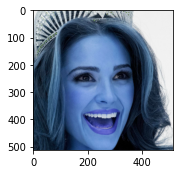

In [61]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(test[0][0][0])

In [62]:
image_size = 512
train_path = "dataset\\"
epochs = 100
batch_size = 8
train_ids = list(map(lambda x: x.split(".")[0], next(os.walk(train_path+"images\\"))[2]))
val_data_size = 10
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

In [63]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

In [64]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x[0].shape, y.shape)

(512, 512, 3) (8, 512, 512, 3)


In [65]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

shape = (512, 512, 3)
num_classes = 3
model = build_unet(shape, num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])

In [66]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

In [67]:
train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

In [68]:
model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs)

Epoch 1/100
11/11 [==============================] - 11s 865ms/step - loss: 2.6074 - acc: 0.7732 - val_loss: 2.3954 - val_acc: 0.5973
Epoch 2/100
11/11 [==============================] - 4s 328ms/step - loss: 2.4662 - acc: 0.8856 - val_loss: 2.8337 - val_acc: 0.9978
Epoch 3/100
11/11 [==============================] - 4s 332ms/step - loss: 2.5105 - acc: 0.7994 - val_loss: 2.8412 - val_acc: 0.9931
Epoch 4/100
11/11 [==============================] - 4s 320ms/step - loss: 2.4395 - acc: 0.7300 - val_loss: 2.8372 - val_acc: 0.9907
Epoch 5/100
11/11 [==============================] - 4s 321ms/step - loss: 2.5183 - acc: 0.6920 - val_loss: 2.8362 - val_acc: 0.0386
Epoch 6/100
11/11 [==============================] - 4s 324ms/step - loss: 2.5713 - acc: 0.7765 - val_loss: 2.8669 - val_acc: 0.0203
Epoch 7/100
11/11 [==============================] - 3s 263ms/step - loss: 2.6853 - acc: 0.7606 - val_loss: 2.8973 - val_acc: 0.0062
Epoch 8/100
11/11 [==============================] - 2s 141ms/step -

In [69]:
## Save the Weights
model.save_weights("UNetW.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)

result = model.predict(x)

result = result > 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted Mask')

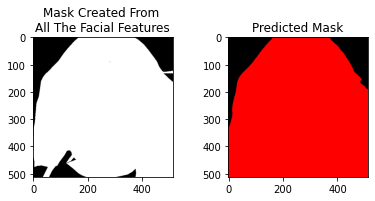

In [82]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

index = 1

ax = fig.add_subplot(1, 2, 1)
ax.imshow(y[index]*255, cmap="gray")
ax.set_title("Mask Created From \nAll The Facial Features")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(result[index]*255, cmap="gray")
ax.set_title("Predicted Mask")